## SSMI Ice data
### Cartopy quicklook

This notebook provides guidance to visualize SSMI data after it has been processed from raw binary data to csv data with columns of ice_concentration, latitude, and longitude.  It regrids the data to the users choice (default = 0.25x0.25 degree) by declaring the number of columns of latitude and longitude.

There is also timing components built in to see if and where the ingest/gridding/plotting can be spead up

__pyversion__==3.7   
__author__==S.Bell

In [1]:
import numpy as np
import datetime

import pandas as pd

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io import shapereader
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import timeit

In [2]:
df = pd.read_csv('/Users/bell/in_and_outbox/data_sets/gsfc_bootstrap_seaice_v3/daily/1978/bt_19781231_n07_v3.1_n.csv')


In [3]:
df.describe()

,grid_area,ice_conc,latitude,longitude
count,136192.000000,136192.000000,136192.000000,136192.000000
mean,555.540872,16.472752,57.624520,17.489821
std,65.681213,36.083450,12.239096,104.975745
min,382.659000,0.000000,31.102670,-180.000000
25%,504.298000,0.000000,47.900800,-70.346180
50%,561.330500,0.000000,56.940085,6.666425
75%,609.645500,0.000000,66.304733,115.033140
max,664.449000,100.000000,89.836820,179.813980


## options for thinning data out

In [4]:
### set a range of lats and lons
# not advised as this messes with gridding assumptions later
#df.drop(df.loc[((df['latitude']<=45) | (df['latitude']>=75))].index, inplace=True)
#df.drop(df.loc[((df['longitude']<=-180) | (df['longitude']>=-150))].index, inplace=True)

### remove 0's by either dropping and making database smaller or by replacing with nans
# not advised for highly regional views as code may interpolate over these gaps oddly 
# . or zeros may be actual (polynas).  Global views may be ok and speed up though

#df.drop(df.loc[df['ice_conc']==0].index, inplace=True)
# or
df['ice_conc'][df['ice_conc']==0] = np.nan

/Users/bell/anaconda2/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [5]:
df.describe()

,grid_area,ice_conc,latitude,longitude
count,136192.000000,24417.000000,136192.000000,136192.000000
mean,555.540872,91.880944,57.624520,17.489821
std,65.681213,18.267596,12.239096,104.975745
min,382.659000,10.000000,31.102670,-180.000000
25%,504.298000,95.000000,47.900800,-70.346180
50%,561.330500,100.000000,56.940085,6.666425
75%,609.645500,100.000000,66.304733,115.033140
max,664.449000,100.000000,89.836820,179.813980


In [6]:
#define the basic map projection information and figure size

def make_map(projection=ccrs.PlateCarree()):
    fig, ax = plt.subplots(figsize=(10.5, 10.5),
                           subplot_kw=dict(projection=projection))
    if projection == ccrs.PlateCarree():
        gl = ax.gridlines(draw_labels=True)
        gl.xlabels_top = gl.ylabels_right = False
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
    return fig, ax

#download land mask
# 50m is a good balance between dataset size and land feature resolution
land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='1.0')

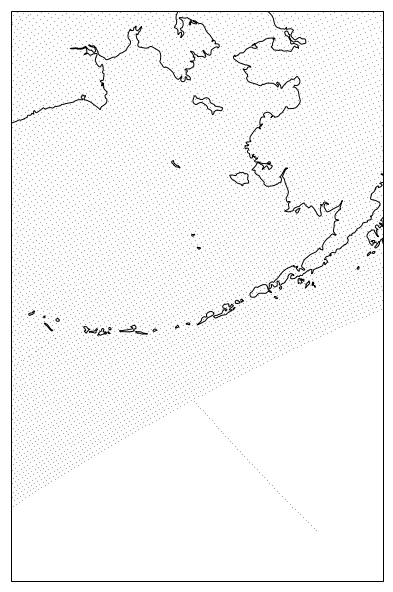

In [7]:
### Plot location of sample points for general BS region
extent = [-180, -155, 40, 67]
projection=ccrs.LambertConformal(central_longitude=200.0)
transformation=ccrs.PlateCarree()
fig,ax = make_map(projection=projection)

ax.plot(df.longitude,df.latitude,'k.',markersize=.25,transform=transformation)
ax.add_feature(land_50m)
ax.coastlines(resolution='50m')
ax.set_extent(extent)

In [8]:
### Remapping the modes from the analysis
from scipy import interpolate
from matplotlib.mlab import griddata
import cmocean

#-- Now let's grid your data.
# First we'll make a regular grid to interpolate onto. This is equivalent to
# your call to `mgrid`, but it's broken down a bit to make it easier to
# understand. 

#The number of columns and rows can be directly linked to the grid resolution
#360 cols would be 1deg resolution... 180 cols would be 2deg resolution
#the more columns, the slower the gridding process but the smoother the plot.  Too
#many columns will lead to oversampling so .25x.25 is probably the highest I would go

numcols, numrows = 360*4, 90*4
xi = np.linspace(df.longitude.min(), df.longitude.max(), numcols)
yi = np.linspace(df.latitude.min(), df.latitude.max(), numrows)
xi, yi = np.meshgrid(xi, yi)

#-- Interpolate at the points in xi, yi
# "griddata" expects "raw" numpy arrays, so we'll pass in
# data.x.values instead of just the pandas series data.x

In [9]:
#%%timeit
# regridding data with 0's removed data
x, y, z = df.longitude.values, df.latitude.values, df.ice_conc.values
zi = interpolate.griddata((x, y),z, (xi, yi), method='linear')

### Global Map

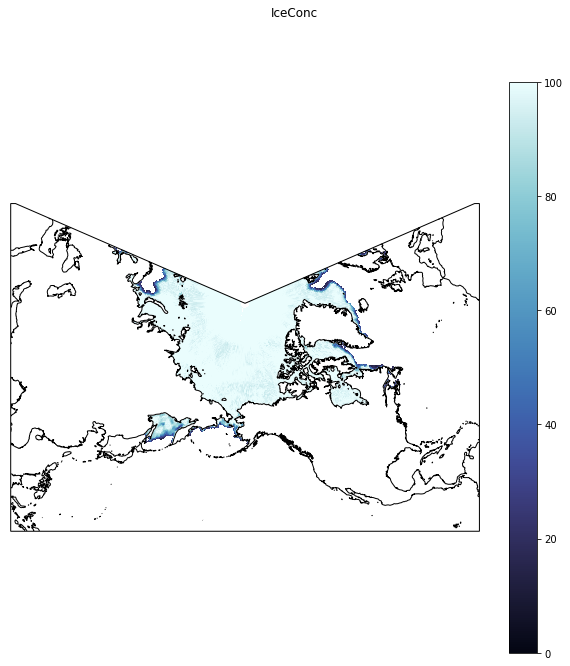

In [10]:
#%%timeit
projection=ccrs.LambertConformal(central_longitude=200.0)
transformation=ccrs.PlateCarree()
fig, ax = make_map(projection=projection)
#uncomment the following line if you want to see all the sample locations
#ax.plot(df.longitude.values,df.latitude.values,'k.',markersize=.25,transform=transformation)
cm=ax.pcolormesh(xi,yi,zi,transform=transformation,cmap=cmocean.cm.ice, vmin=0, vmax=100)
plt.colorbar(cm)
ax.add_feature(land_50m)
ax.coastlines(resolution='50m')
t = fig.suptitle('IceConc')

### Zoom to Alaska Region

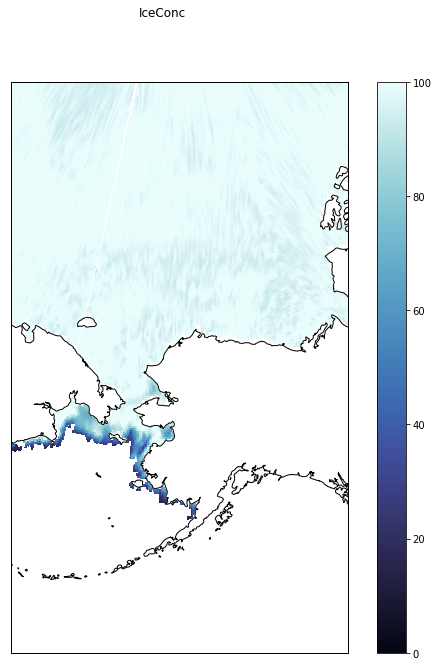

In [11]:
extent = [180, 220, 45, 85]
projection=ccrs.LambertConformal(central_longitude=200.0)
transformation=ccrs.PlateCarree()
fig, ax = make_map(projection=projection)

#ax.plot(df.longitude.values,df.latitude.values,'k.',markersize=.25,transform=transformation)
cm=ax.pcolormesh(xi,yi,zi,transform=transformation,cmap=cmocean.cm.ice, vmin=0, vmax=100)
plt.colorbar(cm)
ax.add_feature(land_50m)
ax.coastlines(resolution='50m')
ax.set_extent(extent)
t = fig.suptitle('IceConc')

### Zoom to Alaska Region and plot C2

lat = 164.105
lon = 71.230 

In [12]:
lat = 180-164.105+180
lon = 71.230 

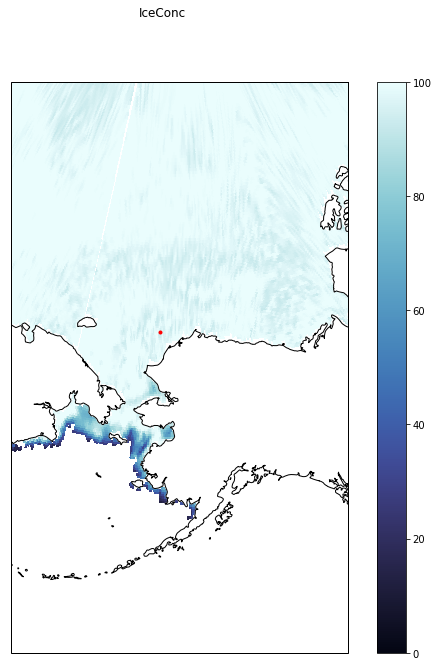

In [13]:
extent = [180, 220, 45, 85]
projection=ccrs.LambertConformal(central_longitude=200.0)
transformation=ccrs.PlateCarree()
fig, ax = make_map(projection=projection)

#ax.plot(df.longitude.values,df.latitude.values,'k.',markersize=.25,transform=transformation)
cm=ax.pcolormesh(xi,yi,zi,transform=transformation,cmap=cmocean.cm.ice, vmin=0, vmax=100)
ax.plot(lat,lon,'r.',transform=transformation)
plt.colorbar(cm)
ax.add_feature(land_50m)
ax.coastlines(resolution='50m')
ax.set_extent(extent)
t = fig.suptitle('IceConc')

### Import xarray and convert data file

In [14]:
import xarray as xr

In [15]:
df

,grid_area,ice_conc,latitude,longitude
0,382.659,NaN,31.10267,168.32042
1,383.385,NaN,31.19941,168.14875
2,384.108,NaN,31.29580,167.97641
3,384.829,NaN,31.39183,167.80338
4,385.546,NaN,31.48750,167.62969
...,...,...,...,...
136187,410.979,NaN,34.88677,-10.72562
136188,410.210,NaN,34.78367,-10.54276
136189,409.439,NaN,34.68019,-10.36070
136190,408.664,NaN,34.57632,-10.17944


In [90]:
xdf = xr.Dataset({'ice': (['x', 'y'],  df.ice_conc.values.reshape(512,266))},
                 coords={'lon': (['x', 'y'], df.longitude.values.reshape(512,266)),
                         'lat': (['x', 'y'], df.latitude.values.reshape(512,266))})

MissingDimensionsError: 'lon' has more than 1-dimension and the same name as one of its dimensions ('lon', 'lat'). xarray disallows such variables because they conflict with the coordinates used to label dimensions.